In [ ]:
!apt-get -qq install fonts-nanum

Selecting previously unselected package fonts-nanum.
(Reading database ... 126101 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.86k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1482 [00:00<?, ?it/s]

Batches:   0%|          | 0/1482 [00:00<?, ?it/s]

Batches:   0%|          | 0/1482 [00:00<?, ?it/s]

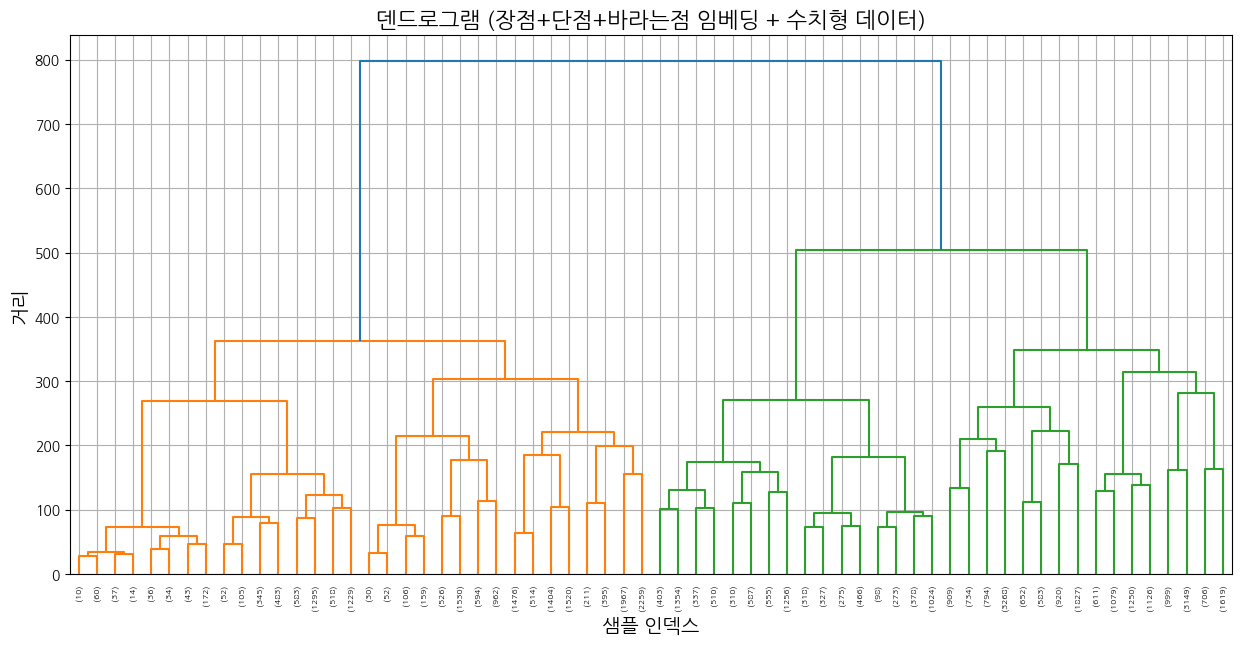

In [ ]:
# 1. 라이브러리 불러오기
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import TruncatedSVD
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 2. 한글 폰트 설정 (나눔고딕)
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
nanum_font = fm.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = nanum_font
plt.rcParams['axes.unicode_minus'] = False

# 3. 데이터 불러오기
df = pd.read_csv('chemistry_all.csv')

# 4. 서비스업만 필터링
df_chemistry = df[df['업종'] == '제조/화학'].copy()

# 총점이 3 이상이면 긍정(1), 그렇지 않으면 부정(0)
df_chemistry['긍정평가'] = (df_chemistry['총점'] >= 3).astype(int)

# 5. 텍스트 전처리 (불필요한 라벨 제거)
def clean_leading_label(text, label):
    if pd.isnull(text):
        return ''
    return text.replace(label, '').strip()

df_chemistry['장점'] = df_chemistry['장점'].apply(lambda x: clean_leading_label(x, '장점\n'))
df_chemistry['단점'] = df_chemistry['단점'].apply(lambda x: clean_leading_label(x, '단점\n'))
df_chemistry['경영진에 바라는점'] = df_chemistry['경영진에 바라는점'].apply(lambda x: clean_leading_label(x, '경영진에 바라는 점\n'))

# 6. BERT 임베딩 모델 로드
embedding_model = SentenceTransformer("sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens")

# 7. 장점, 단점, 바라는점 각각 임베딩
embeddings_strengths = embedding_model.encode(df_chemistry['장점'].fillna('').tolist(), show_progress_bar=True)
embeddings_weaknesses = embedding_model.encode(df_chemistry['단점'].fillna('').tolist(), show_progress_bar=True)
embeddings_requests = embedding_model.encode(df_chemistry['경영진에 바라는점'].fillna('').tolist(), show_progress_bar=True)

# 8. 수치형 데이터 추출 (스케일링 없이)
numeric_features = ['총점', '승진기회', '복지/급여', '워라밸', '사내문화', '경영진', '기업추천여부']
X_numeric = df_chemistry[numeric_features].fillna(0).values

# 9. 텍스트 임베딩 + 수치형 결합
X_combined = np.hstack([embeddings_strengths, embeddings_weaknesses, embeddings_requests, X_numeric])

# 10. 차원 축소 (SVD)
#svd = TruncatedSVD(n_components=100, random_state=42)
#X_reduced = svd.fit_transform(X_combined)

# 11. Ward Linkage 군집화
Z = linkage(X_combined, method='ward')

# 12. 덴드로그램 시각화
plt.figure(figsize=(15, 7))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('덴드로그램 (장점+단점+바라는점 임베딩 + 수치형 데이터)', fontsize=16)
plt.xlabel('샘플 인덱스', fontsize=14)
plt.ylabel('거리', fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# 16. 군집 3개로 나누기
df_chemistry['cluster'] = fcluster(Z, t=3, criterion='maxclust')

# 17. 군집별 샘플 출력 (3개씩)
cluster_samples = {}
for c in sorted(df_chemistry['cluster'].unique()):
    cluster_samples[c] = df_chemistry[df_chemistry['cluster'] == c][['장점', '단점', '통합평가']].head(3).to_dict(orient='records')

# 결과 확인
print(df_chemistry[['cluster', '장점', '단점', '통합평가']].head())
cluster_samples

   cluster                                                 장점  \
0        1                    계약직이 었지만 일할 수 있느 여러 환경 만족스러웠습니다   
1        3  일단 회사의 환경 자체가 굉장히 좋고요, 그것과 더불어서 회사 자체의 이미지가 좋아...   
2        1                   아침 점심 저녁 무료 여름휴가 2주 워라밸 괜찮은 편입니다   
3        1       안정적입니다. 큰 변화는 없지만 그래도 시대에 발맞춰 모두가 열심히 노력합니다.   
4        1                     점심도 주고 칼퇴 가능하여 워라밸이 보장되는 회사입니다   

                                                  단점  \
0           단점은 약간 윗분들이 고지식한 부분이 있어서 시키는대로 무조건 해야합니다   
1            아쉬운 점이라면 본가가 수도권인 사람에게는 너무 멀다는 것이 단점입니다   
2                     계약 연장이 어려움 부서별로 연장근무 하는 부서가 많음   
3  근무과 성과에 대해 적절한 평가가 되고 있는지 모르겠습니다. 이 부분이 개선되어야 ...   
4         교통편이 너무 안좋나 자차 소지자가 아니면 출퇴근이 힘들고 주차가 협소합니다   

                                               통합평가  
0                         일하기 좋은 근무환경과 급여도 나쁘지 않습니다  
1              너무 좋습니다. 미래가 창창하고 앞으로도 다니기 좋을 것 같습니다  
2                               계약직은 워라밸 잘지켜지고 편합니다  
3  변화를 열심히 추구하고 있습니다. 근무환경은 아주 좋지 않지만 회사 자체는 탄탄합니다.  
4 

{np.int32(1): [{'장점': '계약직이 었지만 일할 수 있느 여러 환경 만족스러웠습니다',
   '단점': '단점은 약간 윗분들이 고지식한 부분이 있어서 시키는대로 무조건 해야합니다',
   '통합평가': '일하기 좋은 근무환경과 급여도 나쁘지 않습니다'},
  {'장점': '아침 점심 저녁 무료 여름휴가 2주 워라밸 괜찮은 편입니다',
   '단점': '계약 연장이 어려움 부서별로 연장근무 하는 부서가 많음',
   '통합평가': '계약직은 워라밸 잘지켜지고 편합니다'},
  {'장점': '안정적입니다. 큰 변화는 없지만 그래도 시대에 발맞춰 모두가 열심히 노력합니다.',
   '단점': '근무과 성과에 대해 적절한 평가가 되고 있는지 모르겠습니다. 이 부분이 개선되어야 할 것 같습니다.',
   '통합평가': '변화를 열심히 추구하고 있습니다. 근무환경은 아주 좋지 않지만 회사 자체는 탄탄합니다.'}],
 np.int32(2): [{'장점': '일을 많이 배울 수 있고 사람들이 다 좋다. 자잘한 복지도 있고 해비치 씨마크 등 호텔 사용 가능',
   '단점': '근무 환경이 안좋고 매연이 등이 심함. 시설이 노후화 되어있고 울산 동구라 인프라가 좋지 않음.',
   '통합평가': '적당히 괜찮은 대기업으로 요즘 업황이 좋아서 분위기가 좋음.'},
  {'장점': '울산에서 이름은 알아줌\n중소,중견 기업에 비해 복지는 좋음.\n여름 휴가 길어서 정말 좋음.',
   '단점': '유명하고 복지가 존재는 하는 중견기업과 같다.\n사람을 쥐어짠다.',
   '통합평가': '유명하고 여름 휴가가 긴 울산의 중견기업'},
  {'장점': '하계휴가 2주(현차보다 좋음)\n빨간날 많은 편이노 여기도 노조 관련하면 휴식함(계약직,기장,수석은 제외)\n최근에 조선업이 호재라서 월급도 많이 올랐슴',
   '단점': '매년 중대재해가 일어남\n생산직은 작업환경이 안 좋음(여름에 덥고 겨울에 춥고) 중대재해도 발생하는 환경\n오토바이 타고 다녀야함\n구시대적인 회

In [ ]:
# 1. 필요한 라이브러리
import numpy as np
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

# 2. BERTopic 초기화
embedding_model = SentenceTransformer("sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens")
vectorizer_model = CountVectorizer(ngram_range=(1, 1), stop_words=None)

# 3. 수치형 컬럼 리스트
numeric_features = ['총점', '승진기회', '복지/급여', '워라밸', '사내문화', '경영진', '기업추천여부']

# 4. 군집별로 수치형 스코어 + 키워드 요약
for c in sorted(df_chemistry['cluster'].unique()):
    print(f"\n\n=========== [군집 {c}] ===========\n")

    # (1) 군집별 수치형 변수 평균
    temp = df_chemistry[df_chemistry['cluster'] == c]
    numeric_means = temp[numeric_features].mean().round(2)

    print("군집별 평균 스코어")
    for col in numeric_features:
        print(f"- {col}: {numeric_means[col]}")

    # (2) 군집별 BERTopic 적용 및 핵심 키워드 출력
    print("\n 군집별 핵심 키워드 (BERTopic 기반)")
    for col in ['장점', '단점', '경영진에 바라는점']:
        texts = temp[col].fillna('').tolist()
        if len([t for t in texts if t.strip()]) < 5:
            print(f"  ▶ {col} 데이터가 부족하여 키워드 분석 생략")
            continue

        topic_model = BERTopic(
            embedding_model=embedding_model,
            vectorizer_model=vectorizer_model,
            top_n_words=7,
            min_topic_size=5,
            verbose=False
        )
        topics, _ = topic_model.fit_transform(texts)
        topic_info = topic_model.get_topic_info()
        top_topic = topic_info.iloc[1]['Topic'] if len(topic_info) > 1 else 0
        keywords = [word for word, _ in topic_model.get_topic(top_topic)]
        print(f"  ▶ {col} Top 7 키워드: {keywords}")



=========== [군집 1] ===========

✅ 군집별 평균 스코어
- 총점: 2.92
- 승진기회: 2.7
- 복지/급여: 2.94
- 워라밸: 2.83
- 사내문화: 2.7
- 경영진: 2.3
- 기업추천여부: 0.4

✅ 군집별 핵심 키워드 (BERTopic 기반)
  ▶ 장점 Top 7 키워드: ['배울', '전문성을', '업무를', '배우기', '다양한', '전반적인', '확실해']
  ▶ 단점 Top 7 키워드: ['서울', '삼성', '한국', '거제', '서울에서', '삼성전자', '군대문화']
  ▶ 경영진에 바라는점 Top 7 키워드: ['근무환경', '개선', '조직', '문화', '업무환경', '근무', '그대화']


=========== [군집 2] ===========

✅ 군집별 평균 스코어
- 총점: 2.77
- 승진기회: 2.75
- 복지/급여: 2.89
- 워라밸: 2.73
- 사내문화: 2.6
- 경영진: 2.12
- 기업추천여부: 0.34

✅ 군집별 핵심 키워드 (BERTopic 기반)
  ▶ 장점 Top 7 키워드: ['높은', '연봉이', '위로', '상승하고', '성장', '인지도가', '몇년간']
  ▶ 단점 Top 7 키워드: ['서울', '서울에서', '한국', '서울이나', '서울에', '근무지가', '서울로']
  ▶ 경영진에 바라는점 Top 7 키워드: ['보고서를', '사람이랑', '경영진', '백신', '사장', '임원들은', '최악의']


=========== [군집 3] ===========

✅ 군집별 평균 스코어
- 총점: 3.22
- 승진기회: 3.01
- 복지/급여: 3.24
- 워라밸: 3.07
- 사내문화: 3.03
- 경영진: 2.58
- 기업추천여부: 0.52

✅ 군집별 핵심 키워드 (BERTopic 기반)
  ▶ 장점 Top 7 키워드: ['연차사용', '연차', '연차는', '사용이', '연차사용이', '사용', '자유롭고']
  ▶ 단점 Top 7 키워드: [

In [ ]:
# 수치형 변수 리스트
numeric_features = ['총점', '승진기회', '복지/급여', '워라밸', '사내문화', '경영진', '기업추천여부']

# 군집별 기초통계량 (describe는 count, mean, std, min, 25%, 50%, 75%, max 포함)
cluster_stats = df_chemistry.groupby('cluster')[numeric_features].describe()

# 보기 좋게 인덱스 정리
cluster_stats = cluster_stats.reset_index()

# 결과 출력
import pandas as pd
pd.set_option('display.max_columns', None)  # 모든 컬럼 보기
display(cluster_stats)

cluster       총점                                                  승진기회  \
             count      mean       std  min  25%  50%  75%  max    count   
0       1  18721.0  2.916564  1.163633  1.0  2.0  3.0  4.0  5.0  18721.0   
1       2   8471.0  2.768740  1.082542  1.0  2.0  3.0  3.0  5.0   8471.0   
2       3  20226.0  3.221695  1.081178  1.0  3.0  3.0  4.0  5.0  20226.0   

                                                  복지/급여                      \
       mean       std  min  25%  50%  75%  max    count      mean       std   
0  2.701672  1.105562  1.0  2.0  3.0  3.0  5.0  18721.0  2.941883  1.199777   
1  2.750443  1.018045  1.0  2.0  3.0  3.0  5.0   8471.0  2.888561  1.137262   
2  3.008108  1.040839  1.0  2.0  3.0  4.0  5.0  20226.0  3.241719  1.130961   

                                워라밸                                          \
   min  25%  50%  75%  max    count      mean       std  min  25%  50%  75%   
0  1.0  2.0  3.0  4.0  5.0  18721.0  2.833235  1.279593  1.0  2.0  3.0  4.0   
1  1.0  2.0  3.0  4.0  5.0   8471.0  2.725298  1.263873  1.0  2.0  3.0  4.0   
2  1.0  3.0  3.0  4.0  5.0  20226.0  3.066944  1.247977  1.0  2.0  3.0  4.0   

           사내문화                                                   경영진  \
   max    count      mean       std  min  25%  50%  75%  max    count   
0  5.0  18721.0  2.703755  1.221973  1.0  2.0  3.0  4.0  5.0  18721.0   
1  5.0   8471.0  2.599575  1.205838  1.0  2.0  3.0  3.0  5.0   8471.0   
2  5.0  20226.0  3.034559  1.195725  1.0  2.0  3.0  4.0  5.0  20226.0   

                                                 기업추천여부                      \
       mean       std  min  25%  50%  75%  max    count      mean       std   
0  2.295016  1.159171  1.0  1.0  2.0  3.0  5.0  18721.0  0.396881  0.489264   
1  2.118758  1.056521  1.0  1.0  2.0  3.0  5.0   8471.0  0.344942  0.475377   
2  2.578167  1.150373  1.0  2.0  3.0  3.0  5.0  20226.0  0.517601  0.499702   

                            
   min  25%  50%  75%  max  
0  0.0  0.0  0.0  1.0  1.0  
1  0.0  0.0  0.0  1.0  1.0  
2  0.0  0.0  1.0  1.0  1.0

In [ ]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 132.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unins

# 전체 제조/화학 데이터로 예측

In [ ]:
# 🔹 라이브러리 불러오기
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 1. 데이터 준비
X = df_chemistry[['승진기회', '복지/급여', '워라밸', '사내문화', '경영진', '기업추천여부']]
y = df_chemistry['긍정평가']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 2. 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results = []

# 3. Gradient Boosting
gb_params = {
    'n_estimators': [10, 50, 100],
    'learning_rate': [0.01 ,0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4],
    'subsample': [0.8, 1.0]
}
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=5, scoring='f1', n_jobs=-1)
gb_grid.fit(X_train, y_train)
gb = gb_grid.best_estimator_
y_pred = gb.predict(X_test)
y_prob = gb.predict_proba(X_test)[:, 1]
results.append({
    'Model': 'Gradient Boosting',
    'AUC': roc_auc_score(y_test, y_prob),
    'CA': accuracy_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    '정밀도': precision_score(y_test, y_pred),
    '재현율': recall_score(y_test, y_pred)
})

# 4. Random Forest
rf_params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None,3, 5, 10, 20],
    'max_features': ['sqrt', 'log2', None]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf = rf_grid.best_estimator_
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]
results.append({
    'Model': 'Random Forest',
    'AUC': roc_auc_score(y_test, y_prob),
    'CA': accuracy_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    '정밀도': precision_score(y_test, y_pred),
    '재현율': recall_score(y_test, y_pred)
})

# 5. Neural Network
nn_params = {
    'hidden_layer_sizes': [(100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'max_iter': [200]
}
nn_grid = GridSearchCV(MLPClassifier(random_state=42), nn_params, cv=5, scoring='f1', n_jobs=-1)
nn_grid.fit(X_train_scaled, y_train)
nn = nn_grid.best_estimator_
y_pred = nn.predict(X_test_scaled)
y_prob = nn.predict_proba(X_test_scaled)[:, 1]
results.append({
    'Model': 'Neural Network',
    'AUC': roc_auc_score(y_test, y_prob),
    'CA': accuracy_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    '정밀도': precision_score(y_test, y_pred),
    '재현율': recall_score(y_test, y_pred)
})

# 6. AdaBoost
ab_params = {
    'n_estimators': [20, 50, 100],
    'algorithm': ['SAMME']
}
ab_grid = GridSearchCV(AdaBoostClassifier(random_state=42), ab_params, cv=5, scoring='f1', n_jobs=-1)
ab_grid.fit(X_train, y_train)
ab = ab_grid.best_estimator_
y_pred = ab.predict(X_test)
y_prob = ab.predict_proba(X_test)[:, 1]
results.append({
    'Model': 'AdaBoost',
    'AUC': roc_auc_score(y_test, y_prob),
    'CA': accuracy_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    '정밀도': precision_score(y_test, y_pred),
    '재현율': recall_score(y_test, y_pred)
})

# 7. kNN
knn_params = {
    'n_neighbors': [2, 3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='f1', n_jobs=-1)
knn_grid.fit(X_train_scaled, y_train)
knn = knn_grid.best_estimator_
y_pred = knn.predict(X_test_scaled)
y_prob = knn.predict_proba(X_test_scaled)[:, 1]
results.append({
    'Model': 'kNN',
    'AUC': roc_auc_score(y_test, y_prob),
    'CA': accuracy_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    '정밀도': precision_score(y_test, y_pred),
    '재현율': recall_score(y_test, y_pred)
})

# 최종 결과 출력
df_results = pd.DataFrame(results)
print(df_results.sort_values(by='F1', ascending=False))

               Model       AUC        CA        F1       정밀도       재현율
0  Gradient Boosting  0.918007  0.855546  0.899057  0.883307  0.915379
2     Neural Network  0.918119  0.852383  0.897255  0.878178  0.917179
1      Random Forest  0.917537  0.851856  0.896364  0.881602  0.911628
3           AdaBoost  0.916892  0.850274  0.895925  0.875770  0.917029
4                kNN  0.897876  0.849009  0.893942  0.882697  0.905476


In [ ]:
print("Gradient Boosting best params:", gb_grid.best_params_)
print("Random Forest best params:", rf_grid.best_params_)
print("Neural Network best params:", nn_grid.best_params_)
print("AdaBoost best params:", ab_grid.best_params_)
print("kNN best params:", knn_grid.best_params_)

Gradient Boosting best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Random Forest best params: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Neural Network best params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'max_iter': 200, 'solver': 'adam'}
AdaBoost best params: {'algorithm': 'SAMME', 'n_estimators': 100}
kNN best params: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}


In [ ]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 데이터 분리 및 인덱스 보존
X_all = df_chemistry[['승진기회', '복지/급여', '워라밸', '사내문화', '경영진', '기업추천여부']]
y_all = df_chemistry['긍정평가']
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, stratify=y_all, test_size=0.2, random_state=42
)
train_idx = X_train.index
test_idx = X_test.index

# 전체 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)
df_chemistry_scaled = pd.DataFrame(X_scaled, index=df_chemistry.index, columns=X_all.columns)

# 클러스터별 결과 저장용
cluster_id_map = {original: f"군집{idx+1}" for idx, original in enumerate(sorted(df_chemistry['cluster'].dropna().unique()))}
results_cluster = []

# 군집별 모델 적용
for c in sorted(df_chemistry['cluster'].dropna().unique()):
    cluster_df = df_chemistry[df_chemistry['cluster'] == c]
    cname = cluster_id_map[c]

    X_c = df_chemistry_scaled.loc[cluster_df.index]
    y_c = cluster_df['긍정평가']

    # 인덱스 기반으로 train/test split 유지
    train_ids = train_idx.intersection(cluster_df.index)
    test_ids = test_idx.intersection(cluster_df.index)

    if y_c.loc[train_ids].nunique() < 2 or y_c.loc[test_ids].nunique() < 2:
        continue

    # Gradient Boosting
    gb = GradientBoostingClassifier(learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8, random_state=42)
    gb.fit(X_c.loc[train_ids], y_c.loc[train_ids])
    y_pred = gb.predict(X_c.loc[test_ids])
    y_prob = gb.predict_proba(X_c.loc[test_ids])[:, 1]

    results_cluster.append({
        'Model': 'Gradient Boosting',
        'Cluster': cname,
        'AUC': roc_auc_score(y_c.loc[test_ids], y_prob),
        'CA': accuracy_score(y_c.loc[test_ids], y_pred),
        'F1': f1_score(y_c.loc[test_ids], y_pred),
        '정밀도': precision_score(y_c.loc[test_ids], y_pred),
        '재현율': recall_score(y_c.loc[test_ids], y_pred)
    })

    # Neural Network
    nn = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam',
                       alpha=0.0001, max_iter=200, random_state=42)
    nn.fit(X_c.loc[train_ids], y_c.loc[train_ids])
    y_pred = nn.predict(X_c.loc[test_ids])
    y_prob = nn.predict_proba(X_c.loc[test_ids])[:, 1]

    results_cluster.append({
        'Model': 'Neural Network',
        'Cluster': cname,
        'AUC': roc_auc_score(y_c.loc[test_ids], y_prob),
        'CA': accuracy_score(y_c.loc[test_ids], y_pred),
        'F1': f1_score(y_c.loc[test_ids], y_pred),
        '정밀도': precision_score(y_c.loc[test_ids], y_pred),
        '재현율': recall_score(y_c.loc[test_ids], y_pred)
    })

# 결과 출력
df_cluster_result = pd.DataFrame(results_cluster)
display(df_cluster_result.sort_values(by=['Cluster', 'Model']))

,Model,Cluster,AUC,CA,F1,정밀도,재현율
0,Gradient Boosting,군집1,0.921791,0.852965,0.890069,0.882496,0.897774
1,Neural Network,군집1,0.921039,0.851052,0.889025,0.878471,0.899835
2,Gradient Boosting,군집2,0.908231,0.828839,0.864438,0.856486,0.872540
3,Neural Network,군집2,0.911043,0.832943,0.865248,0.873092,0.857545
4,Gradient Boosting,군집3,0.913636,0.863074,0.912963,0.894196,0.932535
5,Neural Network,군집3,0.913842,0.865259,0.914100,0.897841,0.930958


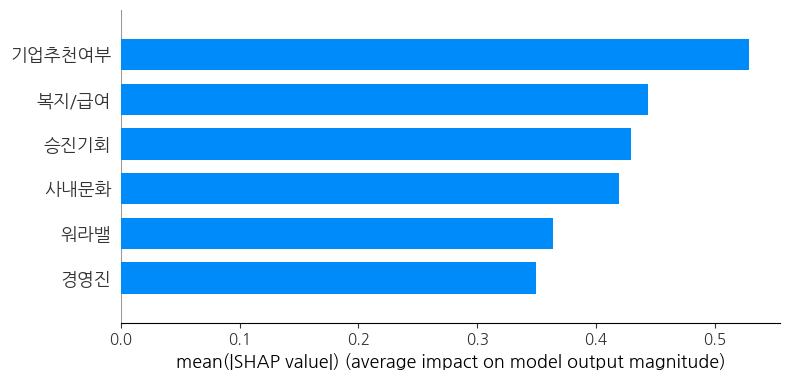

In [ ]:
import shap
import matplotlib.pyplot as plt

# 1. 군집 3 데이터 추출 및 정규화된 값 사용
cluster_3_idx = df_chemistry[df_chemistry['cluster'] == 3].index
X_cluster_3 = df_chemistry_scaled.loc[cluster_3_idx]
y_cluster_3 = df_chemistry.loc[cluster_3_idx, '긍정평가']

# 2. 학습/테스트 인덱스 유지
train_ids = train_idx.intersection(cluster_3_idx)
test_ids = test_idx.intersection(cluster_3_idx)

# 3. Gradient Boosting 모델 정의 및 학습
gb_model = GradientBoostingClassifier(
    learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8, random_state=42
)
gb_model.fit(X_cluster_3.loc[train_ids], y_cluster_3.loc[train_ids])

# 4. SHAP 값 계산 (TreeExplainer 사용)
explainer = shap.TreeExplainer(gb_model)
shap_values = explainer.shap_values(X_cluster_3.loc[test_ids])

# 5. 시각화 (summary_plot)
shap.summary_plot(
    shap_values,
    X_cluster_3.loc[test_ids],
    feature_names=X_cluster_3.columns,
    plot_type="bar"  # 또는 "dot"
)

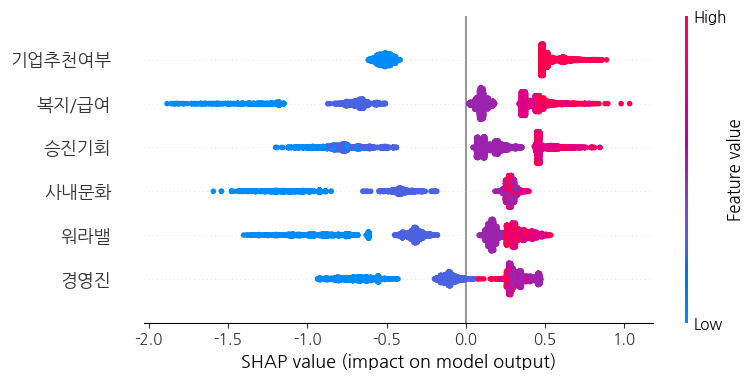

In [ ]:
import shap
import matplotlib.pyplot as plt

# 1. SHAP explainer (Tree 모델이므로 TreeExplainer)
explainer = shap.TreeExplainer(gb_model)

# 2. SHAP 값 계산
shap_values = explainer.shap_values(X_cluster_3.loc[test_ids])

# 3. SHAP summary 분산 plot (dot plot) 시각화
shap.summary_plot(
    shap_values,
    X_cluster_3.loc[test_ids],
    feature_names=X_cluster_3.columns,
    plot_type="dot",       # default; 동일한 스타일
    show=True
)